In [4]:
!pip install dataprep

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Using cached Jinja2-2.11.3-py2.py3-none-any.whl (125 kB)
  Using cached nltk-3.6.2-py3-none-any.whl (1.5 MB)
  Using cached async_timeout-3.0.1-py3-none-any.whl (8.2 kB)
  Created wheel for bokeh: filename=bokeh-2.3.3-py3-none-any.whl size=11342787 sha256=771c7f8db39bef47805e00b169f270ced752b0d0563990f96de6cdbe53b67331
  Stored in directory: c:\users\sebas\appdata\local\pip\cache\wheels\3d\1f\d4\a4ed6f21d242a5e2f4659b0c94d5b590aaf900773103406a97
  Created wheel for bottleneck: filename=Bottleneck-1.3.2-cp38-cp38-win_amd64.whl size=107804 sha256=9a6ff2dde4d4be75b409db9a4de516732ba5b4091cdb5b1a81eab83467fca4f5
  Stored in directory: c:\users\sebas\appdata\local\pip\cache\wheels\2

**Objectif du projet**: <br>
Montrer qu'il est possible d'automatiser l'attribution d'une catégorie en fonction de son **image** et de sa **description**. <br>
Sans réaliser ce projet, l'objectif est de faire une étude de la faisabilité. <br>
--> Faire un clustering pour montrer que des catégories se distinguent. <br>

**A faire**
- Pré-traitement texte + image --> Création de features
- Réduction de dimension
- Clustering

**Objectif du notebook** <br>
Montrer l'intérêt de la description pour catégoriser nos produits. <br>

**A faire**:

- Nettoyer *description* 
    - Suppression de stopword spécifiques
    - Lemmatization
    - 

- Faire un clustering avec un BoW --> Il faudrait réduire la dimension en entrée (taille du vocab.)
    - PCA sur BoW ?
    - Faire un clustering avec features sorties du LDA --> Top 10 mots qui caractérisent notre topic
    
- Faire un clustering avec un tf-idf

- Regarder seconde partie LDA
- Comment mesurer la qualité du LDA ? (Log-likekihood + perplexity ??)
- Comment évaluer la qualité du clustering (Métriques classiques + ARI avec true_labels dans category_product_tree))

---
---
- Nettoyer product_category_tree pour extraire combien (environ) de catégories existe-t-il.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.io as pio
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from datetime import datetime
# Fichier perso
import exploration as ex

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

pd.set_option('plotting.backend', 'plotly')
pd.set_option("display.min_rows", 10)
pd.set_option("display.max_columns", 50)
pd.set_option("max_colwidth", 100)

%reload_ext autoreload
%autoreload 2

# Récupération des datas

In [6]:
from dataprep.eda import create_report

In [2]:
df_desc = pd.read_csv('data\description_product.csv')

In [177]:
df_desc.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                                                                                                       product_url  \
0       http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z   
1                                       http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH   
2                              http://www.flipkart.com/eurospa-cotton-terry-face-towel-set/p/itmeg6shbrpubhca?pid=BTWEG6SHXTDB2A2Y   
3  http://www.flipkart.com/santosh-royal-fashion-cotton-printed-king-sized-double-bedsheet/p/itmejt9uaqahahuf?pid=BDSEJT9UQWHDUBH4   
4            http://www.flipkart.com/jaipur-print-cotton-floral-king-sized-double-bedsheet/p/itmejthnwahrnt7v?pid=BDSEJTHNGWVGWWQU   

                                                      product_name  \
0       Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                       Sathiyas Cotton Bath Towel   
2                              Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet   
4            Jaipur Print Cotton Floral King sized Double Bedsheet   

                                                                                                                       product_category_tree  \
0                           ["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]   
2   ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]   
3    ["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ..."]   
4             ["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Floral King sized Double Bed..."]   

                pid  retail_price  discounted_price  \
0  CRNEG7BKMFFYHQ8Z        1899.0             899.0   
1  BTWEGFZHGBXPHZUH         600.0             449.0   
2  BTWEG6SHXTDB2A2Y           NaN               NaN   
3  BDSEJT9UQWHDUBH4        2699.0            1299.0   
4  BDSEJTHNGWVGWWQU        2599.0             698.0   

                                  image  is_FK_Advantage_product  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg                    False   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg                    False   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg                    False   
3  d4684dcdc759dd9cdf41504698d737d8.jpg                    False   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg                    False   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [9]:
report = create_report(df_desc)

  0%|          | 0/1526 [00:00<?, ?it/s]

In [10]:
report.show_browser()

Je ne garde que les variables contenant des informations utiles à la classification

In [150]:
list(df_desc.columns)

['uniq_id',
 'crawl_timestamp',
 'product_url',
 'product_name',
 'product_category_tree',
 'pid',
 'retail_price',
 'discounted_price',
 'image',
 'is_FK_Advantage_product',
 'description',
 'product_rating',
 'overall_rating',
 'brand',
 'product_specifications']

In [3]:
var_useful = [   
#                  'uniq_id',
#                  'crawl_timestamp', # Quand l'info a été récup
#                  'product_url', # URl de la photo (qui n'existe plus)
                 'product_name', 
                 'product_category_tree', # Dans quelles catégories ces produits sont rangés
#                  'pid', # PID = Product ID ?
                 'retail_price',
#                  'discounted_price', # Prix en solde: Pas intéréssant pour notre classification
                 'image', # Nous permet de lier nos descriptions aux images
#                  'is_FK_Advantage_product',
                 'description',
#                  'product_rating',
#                  'overall_rating',
#                  'brand', 
                 'product_specifications'
             ]

# Exploitation de la colonne product_category_tree

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
import re

In [5]:
def separate_categ(s: str):
    to_return = s.replace('[', '').replace(']', '').replace('&', 'and').replace('"','')
    to_return = to_return.split('>>')
    for ind in range(len(to_return)):
        to_return[ind] = to_return[ind].strip()
    to_return = ','.join(to_return[:])
    to_return = to_return.lower()
    
    to_return = to_return.replace('&', 'and')
    return to_return

separate_categ('oui >> non >> OK >> pas ok')

'oui,non,ok,pas ok'

In [6]:
to_clean = df_desc.product_category_tree.apply(func=separate_categ)
to_clean

0       home furnishing,curtains and accessories,curtains,elegance polyester multicolor abstract eyelet ...
1       baby care,baby bath and skin,baby bath towels,sathiyas baby bath towels,sathiyas cotton bath tow...
2       baby care,baby bath and skin,baby bath towels,eurospa baby bath towels,eurospa cotton terry face...
3       home furnishing,bed linen,bedsheets,santosh royal fashion bedsheets,santosh royal fashion cotton...
4       home furnishing,bed linen,bedsheets,jaipur print bedsheets,jaipur print cotton floral king sized...
                                                       ...                                                 
1045                                           baby care,baby and kids gifts,stickers,oren empower stickers
1046                                             baby care,baby and kids gifts,stickers,wallmantra stickers
1047                                               baby care,baby and kids gifts,stickers,uberlyfe stickers
1048                        

In [7]:
to_clean.isna().sum()

0

J'observe que product_category_tree décompose en de nombreuses sous-catégories, jusqu'à arriver au nom du produit. <br>
Pour l'instant, je ne vais m'intéresser qu'à la 'root' de cet arbre et je vais compter combien de catégories 'primaires' différentes j'ai dans ce dataset. <b>

## Catégories primaires

In [8]:
main_categories = to_clean.apply(func= lambda x: x.split(',')[0])

In [9]:
re.findall(('[^,]+'), main_categories[0])

['home furnishing']

In [10]:
vectorizer = CountVectorizer(token_pattern='[^,]+')
X = vectorizer.fit_transform(main_categories.values)

In [11]:
cv_dataframe=pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())
cv_dataframe

baby care  beauty and personal care  computers  \
0             0                         0          0   
1             1                         0          0   
2             1                         0          0   
3             0                         0          0   
4             0                         0          0   
...         ...                       ...        ...   
1045          1                         0          0   
1046          1                         0          0   
1047          1                         0          0   
1048          1                         0          0   
1049          1                         0          0   

      home decor and festive needs  home furnishing  kitchen and dining  \
0                                0                1                   0   
1                                0                0                   0   
2                                0                0                   0   
3                                0                1                   0   
4                                0                1                   0   
...                            ...              ...                 ...   
1045                             0                0                   0   
1046                             0                0                   0   
1047                             0                0                   0   
1048                             0                0                   0   
1049                             0                0                   0   

      watches  
0           0  
1           0  
2           0  
3           0  
4           0  
...       ...  
1045        0  
1046        0  
1047        0  
1048        0  
1049        0  

[1050 rows x 7 columns]

In [12]:
cv_dataframe.sum().sort_values(ascending=False)

baby care                       150
beauty and personal care        150
computers                       150
home decor and festive needs    150
home furnishing                 150
kitchen and dining              150
watches                         150
dtype: int64

J'ai **7 catégories** primaires avec chacune 150 produits, ces clusters sont équilibrés.

## Catégories secondaires

In [13]:
secondary_categories = to_clean.apply(func=lambda x: x.split(',')[1]) # Je récupère les 2 premières catégories
# secondary_categories = secondary_categories.apply(func= lambda x: ','.join(x)) # J'assemble en une chaine de caractères ces 2 catégories
secondary_categories

0       curtains and accessories
1             baby bath and skin
2             baby bath and skin
3                      bed linen
4                      bed linen
                  ...           
1045         baby and kids gifts
1046         baby and kids gifts
1047         baby and kids gifts
1048         baby and kids gifts
1049         baby and kids gifts
Name: product_category_tree, Length: 1050, dtype: object

In [14]:
re.findall(('[^,]+'), secondary_categories[0])

['curtains and accessories']

In [15]:
vectorizer = CountVectorizer(token_pattern='[^,]+')
X = vectorizer.fit_transform(secondary_categories.values)

In [16]:
cv_dataframe=pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())
cv_dataframe

baby and kids gifts  baby bath and skin  baby bedding  baby grooming  \
0                       0                   0             0              0   
1                       0                   1             0              0   
2                       0                   1             0              0   
3                       0                   0             0              0   
4                       0                   0             0              0   
...                   ...                 ...           ...            ...   
1045                    1                   0             0              0   
1046                    1                   0             0              0   
1047                    1                   0             0              0   
1048                    1                   0             0              0   
1049                    1                   0             0              0   

      bar and glassware  bath and spa  bath linen  beauty accessories  \
0                     0             0           0                   0   
1                     0             0           0                   0   
2                     0             0           0                   0   
3                     0             0           0                   0   
4                     0             0           0                   0   
...                 ...           ...         ...                 ...   
1045                  0             0           0                   0   
1046                  0             0           0                   0   
1047                  0             0           0                   0   
1048                  0             0           0                   0   
1049                  0             0           0                   0   

      bed linen  body and skin care  candles and fragrances  clocks  \
0             0                   0                       0       0   
1             0                   0                       0       0   
2             0                   0                       0       0   
3             1                   0                       0       0   
4             1                   0                       0       0   
...         ...                 ...                     ...     ...   
1045          0                   0                       0       0   
1046          0                   0                       0       0   
1047          0                   0                       0       0   
1048          0                   0                       0       0   
1049          0                   0                       0       0   

      coffee mugs  combos and kits  computer components  computer peripherals  \
0               0                0                    0                     0   
1               0                0                    0                     0   
2               0                0                    0                     0   
3               0                0                    0                     0   
4               0                0                    0                     0   
...           ...              ...                  ...                   ...   
1045            0                0                    0                     0   
1046            0                0                    0                     0   
1047            0                0                    0                     0   
1048            0                0                    0                     0   
1049            0                0                    0                     0   

      consumables and disposables  containers and bottles  cookware  \
0                               0                       0         0   
1                               0                       0         0   
2                               0                       0         0   
3                               0                       0         0   
4          

In [17]:
cv_dataframe.sum().sort_values(ascending=False)

wrist watches                  149
laptop accessories              87
infant wear                     84
coffee mugs                     74
showpieces                      71
                              ... 
dinnerware and crockery          1
men's grooming                   1
beauty accessories               1
kripa's home furnishing          1
consumables and disposables      1
Length: 62, dtype: int64

Les catégories secondaires sont au nombre de 62. <br>
Je remarque en outre que certains labels n'ont qu'une seule occurence (un seul produit à cette catégorie secondaire) <br>

In [18]:
cv_dataframe.sum()[(cv_dataframe.sum() > 30)].sort_values(ascending=False) # Catégories avec + de 30 occurences

wrist watches         149
laptop accessories     87
infant wear            84
coffee mugs            74
showpieces             71
bed linen              65
fragrances             65
network components     49
dtype: int64

... Ces catégories pourront être considérées plus tard

# Exploitation de la colonne description

## Prétraitement de la colonne description

In [19]:
from dataprep.clean import clean_text
from dataprep.eda import plot_missing

  0%|          | 0/51 [00:00<?, ?it/s]


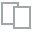
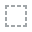
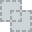
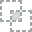
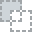
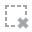
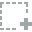
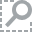
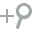
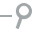
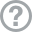
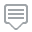
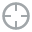
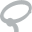
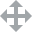
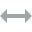
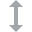
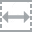
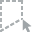
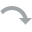
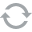
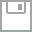
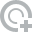
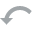
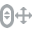
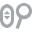
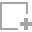
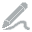
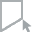
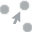
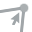
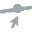

In [93]:
plot_missing(df_desc.description)

---

The default pipeline for the clean_text() function is the following:

    fillna: Replace all null values with NaN.

    lowercase: Convert all characters to lowercase.

    remove_digits: Remove numbers.

    remove_html Remove HTML tags.

    remove_urls: Remove URLs.

    remove_punctuation: Remove punctuation marks.

    remove_accents: Remove accent marks.

    remove_stopwords: Remove stopwords (based on nltk library).

    remove_whitespace: Remove extra spaces, and tabs and newlines.


In [21]:
description = clean_text(df_desc, 'description').description

In [22]:
description.head()

0    key features elegance polyester multicolor abstract eyelet door curtain floral curtain elegance ...
1    specifications sathiyas cotton bath towel bath towel red yellow blue bath towel features machine...
2    key features eurospa cotton terry face towel set size small height inch gsm eurospa cotton terry...
3    key features santosh royal fashion cotton printed king sized double bedsheet royal bedsheet perf...
4    key features jaipur print cotton floral king sized double bedsheet cotton jaipur print cotton fl...
Name: description, dtype: object

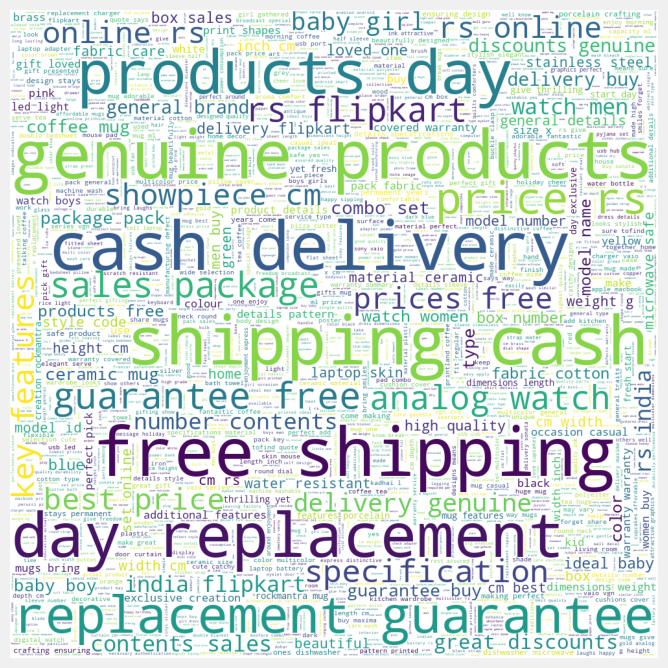

In [23]:
from wordcloud import WordCloud

long_string = ','.join(description.values)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, width=1000, height=1000, contour_color='steelblue')
wordcloud.generate(long_string)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Je repère des stop-words spécifiques à ce dataset

In [24]:
stop_words = ['cash', 'delivery', 'price', 'prices', 'guarantee', 'free', 'flipkart', 'discount', 'discounts', 'sales', 'brand', 'replacement', 'product', 'color', 'material', 'best', 'great',
              'specification', 'cm', 'height', 'width', 'weight', 'key', 'features', 'products', 'buy', 'rs', 'india', 'shipping', 'day', 'online', 'com', 'specifications', 'genuine']

In [25]:
def remove_stopwords(text: str, stop_words: list):
    words = [word for word in text.split() if word.lower() not in stop_words]

    return ' '.join(words)

remove_stopwords('cash truc delivery superprice', stop_words)

'truc superprice'

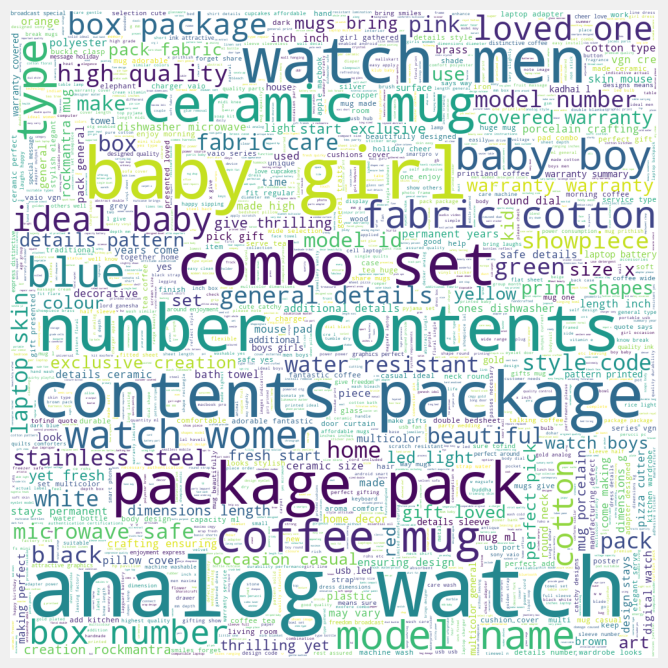

In [26]:
cleaned_desc = description.apply(func=lambda x: remove_stopwords(x, stop_words))

long_string = ','.join(cleaned_desc.values)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, width=1000, height=1000, contour_color='steelblue')
wordcloud.generate(long_string)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [89]:
vectorizer = CountVectorizer(min_df=10)
tf = vectorizer.fit_transform(cleaned_desc)

In [90]:
tf.shape

(1050, 522)

In [91]:
bag_of_words = pd.DataFrame(tf.toarray(),columns=vectorizer.get_feature_names())
bag_of_words.sum().sort_values(ascending=False)[:20]

watch       330
mug         327
baby        319
pack        317
set         311
type        304
cotton      299
box         292
general     288
package     269
analog      262
number      253
warranty    250
quality     244
details     235
model       226
design      225
ceramic     219
laptop      214
fabric      211
dtype: int64

### Sparcity

Pourcentage de non-zero dans ma matrice

In [92]:
# Materialize the sparse data
data_dense = tf.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  2.8025907681080096 %


J'ai 93% de 0 dans mon BoW en sélectionnant les mots avec 10 occurences mini.

## Trouver les mots caractérisant efficacement nos catégories

A l'aide d'un algorithme non-supervisé tel que le LDA ou le NMF, je vais ici chercher à définir quels mots caractérisent une des catégories primaires extraites précédemment

### LDA

https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/ 

In [82]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 7

# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=10, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

# Fitter sur les données
lda.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          n_components=7, random_state=0)

In [47]:
lda.components_[0].argsort()

array([2047,  383,  708, ..., 1233, 4775, 4075], dtype=int64)

In [56]:
tmp = lda.components_[0]

ind = tmp.argsort()

tmp[ind[:-10-1:-1]]

array([166.23163084, 123.32385273, 105.37848467, 103.53724632,
       100.10643395,  99.97290498,  86.09152127,  82.5610668 ,
        77.73440037,  70.50886071])

In [83]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])) # Je récupère les mots avec le meilleur score pour ce topic

no_top_words = 20
display_topics(lda, vectorizer.get_feature_names(), no_top_words)

Topic 0:
warranty set combo showpiece multicolor general box package model number pack contents name suitable easy resistant type made size black
Topic 1:
type box general ideal ml yes pack use model number water name body package easy size dimensions wash girls boys
Topic 2:
baby cotton fabric details girl wash ideal pattern care pack general printed package blue contents casual number set type occasion
Topic 3:
design inch pack model package box number dimensions cover type general length contents name id multicolor printed body style black
Topic 4:
watch analog men women dial strap boys round water resistant black girls style warranty blue body code occasion type casual
Topic 5:
quality high made size home also easy designed give use perfect pack multicolor model design resistant warranty printed black body
Topic 6:
mug ceramic perfect gift safe design give ml size details made also home casual quality black yes dimensions depth type


#### Evaluation de ce topic modelling

## Premier K-Means: Bag of Words

Ici l'idée est de faire un K-means avec en input le BoW des descriptions des produits

In [84]:
from sklearn.cluster import KMeans
# from yellowbrick.cluster import SilhouetteVisualizer

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score

### BoW brut

In [85]:
# J'ajoute le true label à mes descriptions cleanés
le = LabelEncoder()

frame = { 'description':cleaned_desc, 'label':le.fit_transform(main_categories)}
true_labels = pd.DataFrame(frame)
true_labels

description  \
0     elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester mul...   
1     sathiyas cotton bath towel bath towel red yellow blue bath towel machine washable yes cotton des...   
2     eurospa cotton terry face towel set size small inch gsm eurospa cotton terry face towel set piec...   
3     santosh royal fashion cotton printed king sized double bedsheet royal bedsheet perfact wedding g...   
4     jaipur print cotton floral king sized double bedsheet cotton jaipur print cotton floral king siz...   
...                                                                                                   ...   
1045  oren empower extra large self adhesive sticker pack double sticker used big walls two pieces arr...   
1046  wallmantra large vinyl sticker sticker pack bring home exclusive piece wall art give home refres...   
1047  uberlyfe extra large pigmented polyvinyl films imported sticker uberlyfe extra large pigmented p...   
1048                      wallmantra medium vinyl sticker sticker wallmantra medium vinyl sticker sticker   
1049                                            uberlyfe large vinyl sticker uberlyfe large vinyl sticker   

      label  
0         4  
1         0  
2         0  
3         4  
4         4  
...     ...  
1045      0  
1046      0  
1047      0  
1048      0  
1049      0  

[1050 rows x 2 columns]

In [86]:
kmeans = KMeans(n_clusters = 7, random_state=42)

kmeans.fit(bag_of_words.values)

KMeans(n_clusters=7, random_state=42)

In [87]:
adjusted_rand_score(true_labels.label, kmeans.labels_)

0.15932913856743744

Le score ARI est extremement faible, le clustering n'est pas donc pas du tout adapté avec ces entrées. <br>
Le manque de précision peut venir de: 
- La dimension trop importante de notre input 
- ...

### Filtrage des mots importants

Ici je ne garde dans mon BoW que les mots sélectionnés par le LDA

---

---

Notes: <br>

- Beaucoup de montres ?
- J'ai le chemin dans lequel est rangé chaque produit
- Brand peut etre utile mais beaucoup de missing values
- Product specification nous donnes les infos précises sur ces produits